<a href="https://colab.research.google.com/github/ricglz/CE888_activities/blob/main/assignment/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies

---

In [ ]:
!pip install torch torchvision skorch timm

# Preparations

---


Before we begin, lets mount the google drive to later on read information from it:

In [ ]:
from google.colab import drive

drive_path = '/content/gdrive'
drive.mount(drive_path, force_remount=False)
drive_path += '/MyDrive'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Next we will set the seeds in everything to make this as deterministic as possible

In [ ]:
import torch
import random
import numpy as np

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

# Gather the dataset

----

For this we will create both our training _(which later on will be splitted into actual training an validation)_ and testing dataset.

Pytorch also allows us to have transformations like the resize and the normalization. The normalization used are [the mean and std of the ImageNet dataset](https://github.com/rwightman/pytorch-image-models/blob/master/timm/data/constants.py)

In [ ]:
import torchvision.transforms as T
from os import path

data_dir = path.join(drive_path, 'Essex/Datasets/Flame')
resize = T.Resize((254, 254))
normalize = T.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])

In [ ]:
train_transforms = T.Compose([
  resize,
  T.ColorJitter(brightness=0.25, contrast=0.25),
  T.RandomRotation(degrees=5),
  T.RandomHorizontalFlip(),
  T.RandomVerticalFlip(),
  T.ToTensor(),
  normalize
])
transforms = T.Compose([
  resize,
  T.ToTensor(),
  normalize
])

In [ ]:
import torchvision.datasets as datasets

train_ds = datasets.ImageFolder(path.join(data_dir, 'Training'),
                                train_transforms)
len(train_ds)

51658

In [ ]:
test_ds = datasets.ImageFolder(path.join(data_dir, 'Test'), transforms)
len(test_ds)

8617

# Create modular model 

---

In [ ]:
from torch.nn import Linear, Module
import timm

f_params = None

class PretrainedModel(Module):
    def __init__(self, model='rexnet'):
        super().__init__()
        model_name = self.get_model_name(model)
        self.model = timm.create_model(
            model_name, pretrained=True, num_classes=1)
    
    def get_model_name(self, general_model):
        return 'rexnet_200' if general_model == 'rexnet' else \
               'tf_efficientnet_b8' if general_model == 'efficientnet' else ''

    def forward(self, x):
        return self.model(x).squeeze(-1)

# Defining the API

---

### Callbacks

In this case the only Callback that will be used in every model will be an early stopping callback

In [ ]:
from skorch.callbacks import EarlyStopping, Freezer, LRScheduler, ProgressBar
from torch.optim.lr_scheduler import MultiplicativeLR, StepLR, LambdaLR

is_not_trainable = lambda x: not x.startswith('model.fc') and \
                            not x.startswith('model._fc') and \
                            not x.startswith('model.head') and \
                            not x.startswith('model.classifier')
freezer = Freezer(is_not_trainable) 
early_stopping = EarlyStopping(patience=3)
progress_bar = ProgressBar()

In [ ]:
lr = 5e-5
num_warmup_steps = 6
num_training_steps = 9
max_lr = 5e-3
min_lr = 1e-5

def lr_lambda(epoch):
    if epoch <= num_warmup_steps:
        return np.log(max_lr / lr) / np.log(num_warmup_steps)
    value = np.log(max_lr / min_lr) / np.log(num_training_steps)
    return 1 - 1 / value

# lr_lambda = lambda epoch: min(2 * epoch / 10, 0.9)
scheduler = LRScheduler(policy=MultiplicativeLR, lr_lambda=lr_lambda)
# scheduler = LRScheduler(policy=StepLR, gamma=8.95e-1, step_size=1)

### Classifier class

In [ ]:
from torch import float64
from skorch.classifier import NeuralNetBinaryClassifier
from skorch.utils import to_tensor, to_numpy
import sklearn.metrics as sk_metrics 
import numpy as np
import matplotlib.pyplot as plt

class MyClassifier(NeuralNetBinaryClassifier):
    def infer(self, x, **fit_params):
        x = to_tensor(x, device=self.device)
        if isinstance(x, dict):
            x_dict = self._merge_x_and_fit_params(x, fit_params)
            return self.module_(**x_dict).to(device=self.device, dtype=float64)
        return self.module_(x, **fit_params).to(device=self.device, dtype=float64)

    def train_step_single(self, Xi, yi, **fit_params):
        self.module_.train()
        y_pred = self.infer(Xi, **fit_params)
        yi = yi.to(device=self.device, dtype=float64)
        loss = self.get_loss(y_pred, yi, X=Xi, training=True)
        loss.backward()
        return { 'loss': loss, 'y_pred': y_pred }

    def validation_step(self, Xi, yi, **fit_params):
        self.module_.eval()
        y_pred = self.infer(Xi, **fit_params)
        yi = yi.to(device=self.device, dtype=float64)
        loss = self.get_loss(y_pred, yi, X=Xi, training=False)
        return { 'loss': loss,'y_pred': y_pred }

    def _get_y_values(self, X):
        y_true, y_pred = [], []
        nonlinearity = self._get_predict_nonlinearity()
        for images, labels in self.get_iterator(X):
            images = images.to(self.device)
            outputs = nonlinearity(self.module_(images))
            _, predicted = torch.max(outputs.data, 1)
            y_true.append(to_numpy(labels))
            y_pred.append(to_numpy(predicted))
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        return y_true, y_pred

    def score(self, X):
        y_true, y_pred = self._get_y_values(X)
        return sk_metrics.roc_auc_score(y_true, y_pred)
    
    def scores(self, X):
        y_true, y_pred = self._get_y_values(X)
        accuracy = sk_metrics.accuracy_score(y_true, y_pred)
        confusion_matrix = sk_metrics.confusion_matrix(y_true, y_pred)
        f1 = sk_metrics.f1_score(y_true, y_pred)
        auc = sk_metrics.roc_auc_score(y_true, y_pred)
        return accuracy, confusion_matrix, f1, auc

    def print_and_plot_scores(self, X):
        accuracy, confusion_matrix, f1, auc = self.scores(X)
        print(f'Accuracy: {accuracy}')
        print(f'F1 Score: {f1}')
        print(f'AUC: {auc}')
        disp = sk_metrics.ConfusionMatrixDisplay(
          confusion_matrix, display_labels=['Fire', 'No_Fire'])
        disp.plot()

    def plot_training_metric(self, values, label):
        plt.plot(range(len(values)), values, label=label)
    
    def plot_training_metrics(self):
        training_loss = self.history[:, 'train_loss']
        valid_acc = self.history[:, 'valid_acc']
        valid_loss = self.history[:, 'valid_loss']

        self.plot_training_metric(training_loss, 'Training loss')
        self.plot_training_metric(valid_acc, 'Validation accuracy')
        self.plot_training_metric(valid_loss, 'Validation loss')

        plt.legend(loc=3)
        plt.title('Model training metrics')
        plt.show()

### Classifier helper functions

The next code will be used to create helper functions to easily create, fit and evaluate different type of CNN architectures

In [ ]:
from torch.optim import Adam
from skorch.callbacks import Checkpoint
from skorch.dataset import CVSplit
from skorch.helper import predefined_split

def create_model(module_model):
    global f_params

    f_params = path.join(drive_path, f'Models/best_{module_model}.pt')
    checkpoint = Checkpoint(f_params=f_params, monitor='valid_acc_best')
    callbacks = [checkpoint, freezer, scheduler]

    return MyClassifier(
        PretrainedModel,
        module__model=module_model,
        optimizer=Adam,
        lr=lr,
        batch_size=32,
        max_epochs=15,
        iterator_train__shuffle=True,
        iterator_train__num_workers=16,
        iterator_valid__shuffle=True,
        iterator_valid__num_workers=16,
        train_split=CVSplit(0.2, random_state=seed),
        callbacks=callbacks,
        device='cuda'
    )

In [ ]:
def create_and_fit(model_name):
    net = create_model(model_name)
    net.fit(train_ds, y=None)
    net.load_params(f_params=f_params)
    return net

# Models results

---

### Rexnet

In [ ]:
rexnet = create_and_fit('rexnet')

  epoch    train_loss    valid_acc    valid_loss    cp      lr       dur
-------  ------------  -----------  ------------  ----  ------  --------
      1        1.4999       0.7718        0.8016     +  0.0001  293.0380


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        0.6732       0.9231        0.3525     +  0.0001  295.2856
      3        0.3963       0.9515        0.2097     +  0.0003  297.3285
      4        0.2323       0.9723        0.1037     +  0.0007  296.0138
      5        0.1361       0.9849        0.0564     +  0.0018  293.6442
      6        0.0824       0.9910        0.0293     +  0.0044  293.3523
      7        0.0598       0.9940        0.0244     +  0.0107  290.4543
      8        0.0409       0.9937        0.0206        0.0068  291.4022
      9        0.0333       0.9955        0.0153     +  0.0043  290.1086
     10        0.0300       0.9956        0.0119     +  0.0027  291.0346
     11        0.0272       0.9959        0.0128     +  0.0017  291.6697
     12        0.0272       0.9959        0.0134        0.0011  290.6482
     13        0.0262       0.9962        0.0136     +  0.0007  287.9412
     14        0.0254       0.9955        0.0120        0.0004  286.8279
     15        0.0293       0.9955        0.0153   

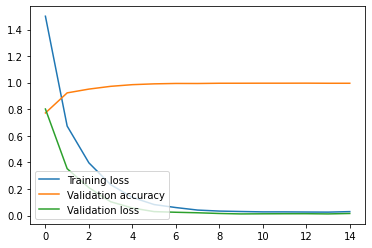

In [ ]:
rexnet.plot_training_metrics()

Accuracy: 0.7146338632934897
F1 Score: 0.5877619446772842
AUC: 0.6806200060861141


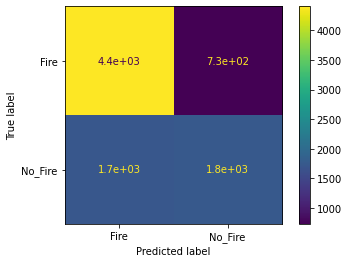

In [ ]:
rexnet.print_and_plot_scores(test_ds)

Accuracy: 0.9962058151689961
F1 Score: 0.9962115354878615
AUC: 0.996205815168996


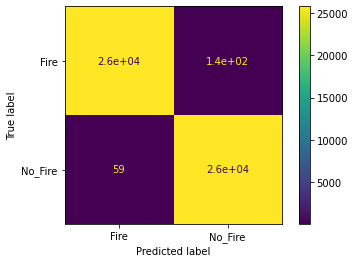

In [ ]:
rexnet.print_and_plot_scores(train_ds)

### EfficientNet

In [ ]:
efficientnet = create_and_fit('efficientnet')

  epoch    train_loss    valid_acc    valid_loss    cp      lr       dur
-------  ------------  -----------  ------------  ----  ------  --------
      1        3.5552       0.5378        2.6645     +  0.0001  932.1130


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2        1.5889       0.7755        1.0483     +  0.0001  831.9048
      3        0.6624       0.8953        0.4627     +  0.0003  831.5775
      4        0.3661       0.9413        0.2446     +  0.0008  832.2669
      5        0.2071       0.9595        0.1553     +  0.0022  833.7178
      6        0.1400       0.9693        0.1164     +  0.0056  833.4824
      7        0.1503       0.9705        0.1167     +  0.0144  832.0795
      8        0.1109       0.9776        0.0837     +  0.0093  833.2175
      9        0.0865       0.9817        0.0699     +  0.0060  833.4093
     10        0.0740       0.9807        0.0643        0.0039  833.3693
     11        0.0720       0.9820        0.0583     +  0.0025  833.2527
     12        0.0641       0.9827        0.0555     +  0.0016  834.3635
     13        0.0602       0.9811        0.0576        0.0011  834.9751
     14        0.0582       0.9832        0.0530     +  0.0007  834.2609
     15        0.0577       0.9798        0.0604   

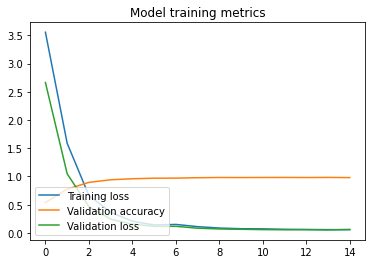

In [ ]:
efficientnet.plot_training_metrics()

Accuracy: 0.6159916444238134
F1 Score: 0.2795558458523841
AUC: 0.5463975015606855


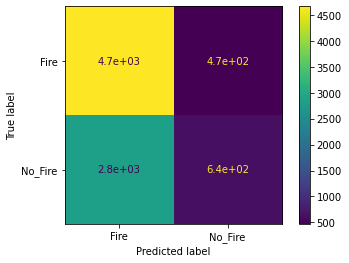

In [ ]:
efficientnet.print_and_plot_scores(test_ds)

Accuracy: 0.9828874520887375
F1 Score: 0.982940291018565
AUC: 0.9828874520887375


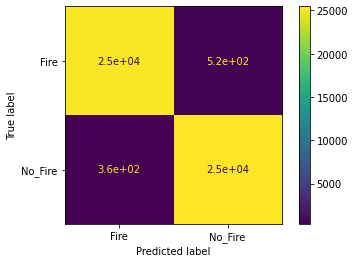

In [ ]:
efficientnet.print_and_plot_scores(train_ds)